In [245]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
from torch import Tensor

from torch.utils.data import DataLoader, Dataset

import numpy as np

import os
import random

from tqdm import tqdm_notebook

from pycrayon import CrayonClient

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

SEED = 7
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

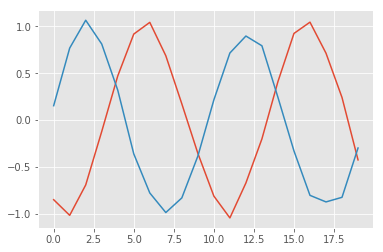

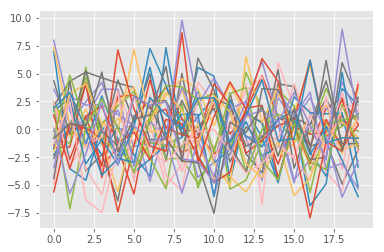

In [268]:
n_layers = 1
G_n_layers = 2
n_hid = 64
D_n_hid = 5
mb_size = 32
seq_len = 20 

rs = (-4,4)
rf = (5,50)


def g_noise():
    return (torch.randn(seq_len, mb_size, 4))*3
    
    
def real_sample():
    shift = np.random.uniform(rs[0], rs[1], mb_size)
    #freq = np.random.uniform(rf[0], rf[1], mb_size)
    freq = np.ones(mb_size) * 6
    support = np.linspace(-1, 1, seq_len)
    seqs = np.array([np.sin((support + shift[i])*freq[i]) 
                   for i in range(mb_size)])
    seqs = seqs.T.reshape(seq_len, mb_size, 1)
    seqs += np.random.normal(size=seqs.shape) * 5e-2
    return Tensor(seqs)

u = real_sample().numpy()
plt.plot(u[:,::20,0])
plt.show()
v = g_noise().numpy()
plt.plot(v[:,:,0])
plt.show()

In [269]:
class Logger():
    def __init__(self, exp_name):
        self.cc = CrayonClient(hostname='localhost')
        names = self.cc.get_experiment_names()
        self.cc.remove_experiment(exp_name)
        self.exp = self.cc.create_experiment(exp_name)
        
    def log_scalar(self, key, val):
        self.exp.add_scalar_value(key, val)
        
    def log_hist(self, key, val):
        self.exp.add_histogram_value(key, val, tobuild=True)

In [270]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.gru = nn.GRU(
            4, 
            n_hid,

            num_layers=G_n_layers,
            dropout=0.0
        )
        self.decode = nn.Linear(n_hid, 1)
        
    def forward(self, z):
        hidden = self.init_hidden()
        output, _ = self.gru(z, hidden)
        output = F.tanh(self.decode(output))
        return output
    
    def init_hidden(self):
        return Variable(
            torch.zeros(G_n_layers, mb_size, n_hid)
        ).cuda()

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.gru = nn.GRU(1, D_n_hid, n_layers, 
                          dropout=0.0, bidirectional=True)
        self.decode = nn.Linear(D_n_hid*2, 1)
    
    def forward(self, X):
        hidden = self.init_hidden()
        output, _ = self.gru(X, hidden)
        output = self.decode(output)
        return output[-1, :, :]
        

    def init_hidden(self):
        return Variable(
            torch.zeros(n_layers*2, mb_size, D_n_hid)
        ).cuda()
    
G = Generator()
D = Discriminator()
G.cuda()
D.cuda()

ones_label = Variable(torch.ones(mb_size, 1)).cuda()
zeros_label = Variable(torch.zeros(mb_size, 1)).cuda()

G_solver = optim.SGD(G.parameters(), lr=1e-4)
D_solver = optim.Adamax(D.parameters(), lr=1e-3)
#G_solver = optim.RMSprop(G.parameters(), lr=1e-3)
#D_solver = optim.RMSprop(D.parameters(), lr=1e-3)

def reset_grad():
    D.zero_grad()
    G.zero_grad() 
G

Generator (
  (gru): GRU(4, 64, num_layers=2)
  (decode): Linear (64 -> 1)
)

In [271]:
def show_seqs(d, i=None, title=None, ds=10):
    d = d.data.cpu().numpy()
    plt.plot(d[:,::ds,0])
    if title:
        plt.title('Loss {}:'.format(title))
    plt.savefig('pics/train_epoch{}.pdf'.format(i))
    plt.plot(d[:,::ds,0])
    if title:
        plt.title('Loss {}:'.format(title))
    plt.show()
    
def show_seqs_nosave(d, i=None, title=None, ds=10):
    d = d.data.cpu().numpy()
    plt.plot(d[:,::ds,0])
    plt.show()   
    
def freeze(model):
    for p in model.parameters():
        p.requires_grad = False

def unfreeze(model):
    for p in model.parameters():
        p.requires_grad = True


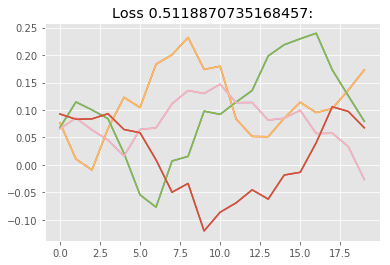

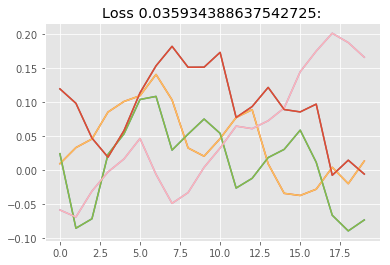

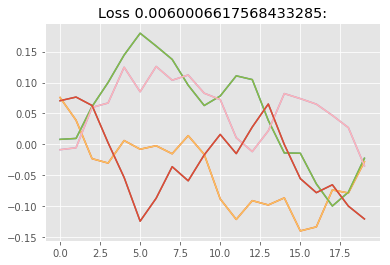

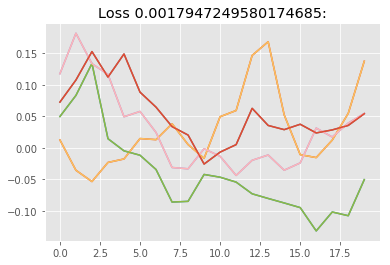

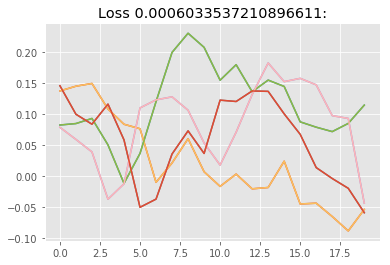

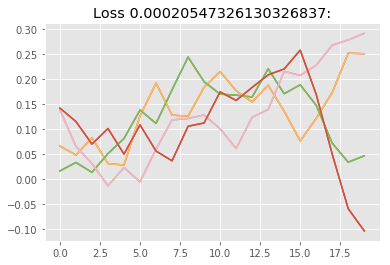

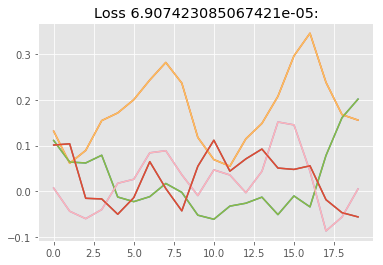

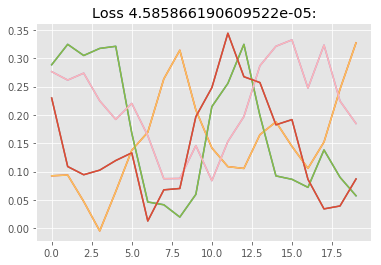

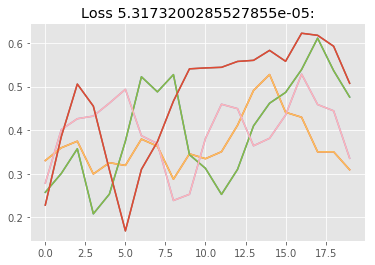

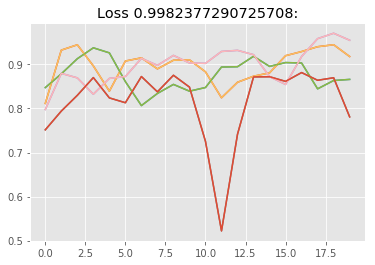

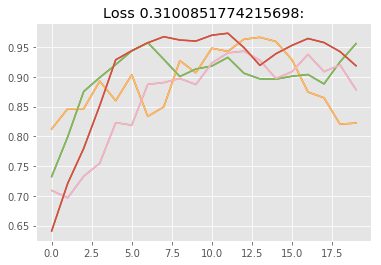

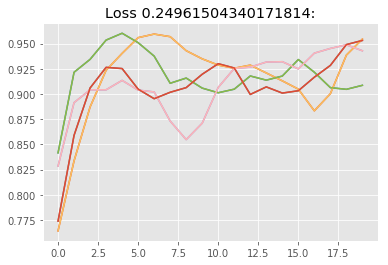

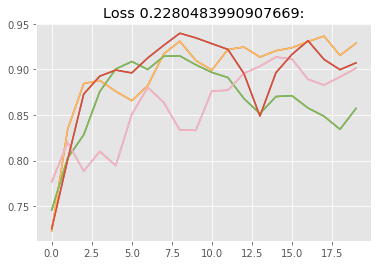

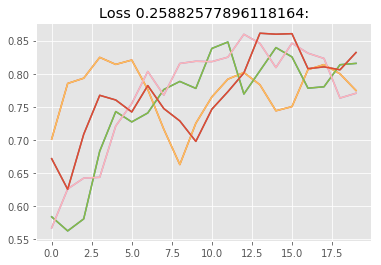

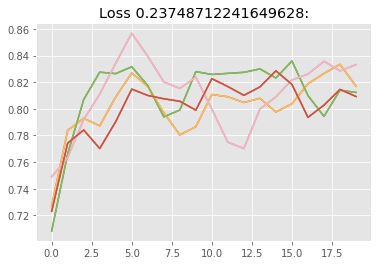

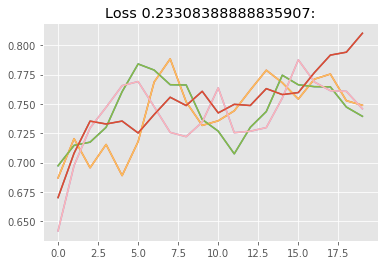

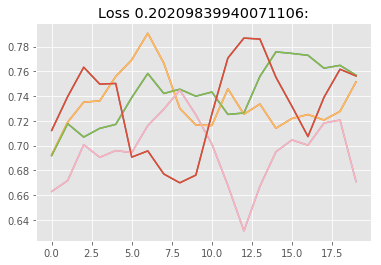

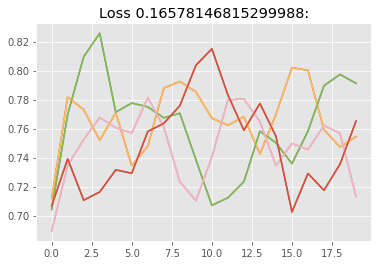

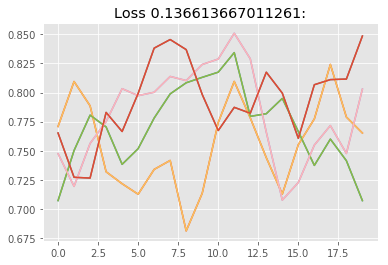

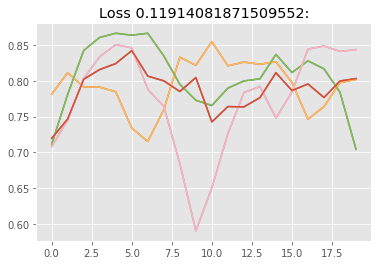

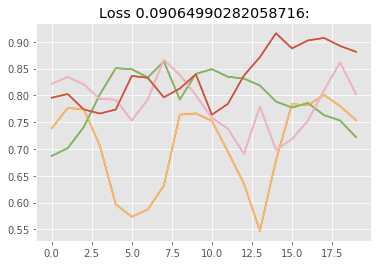

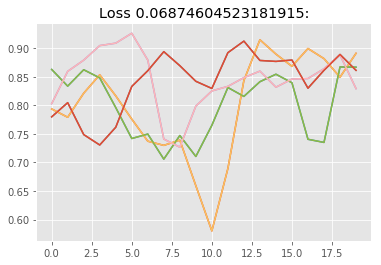

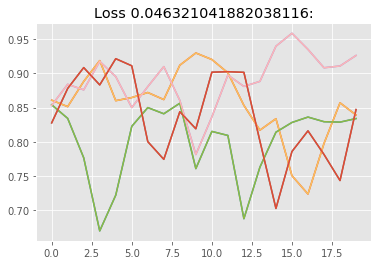

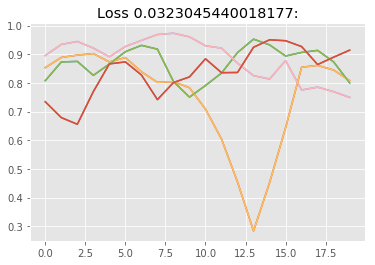

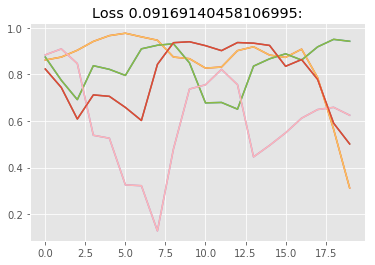

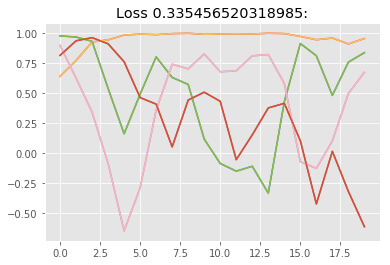

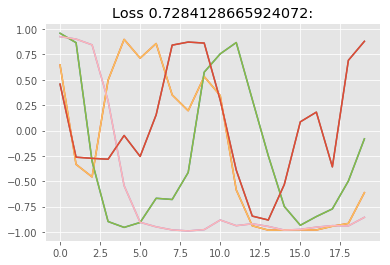

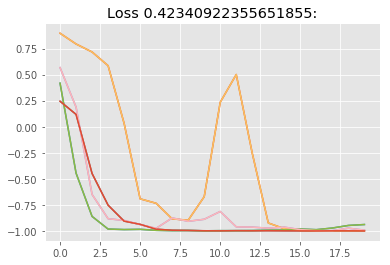

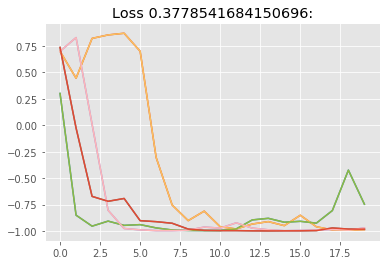

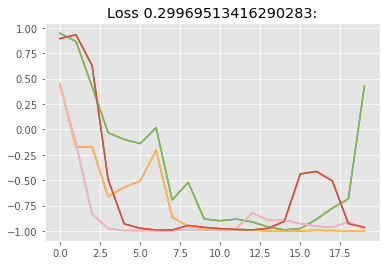

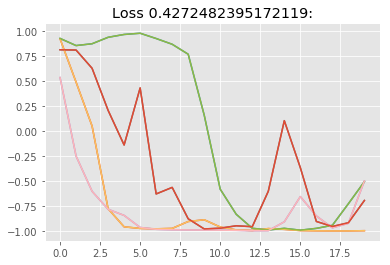

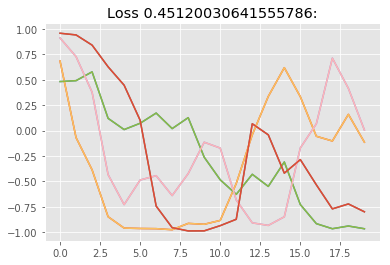

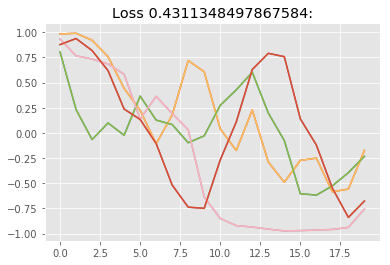

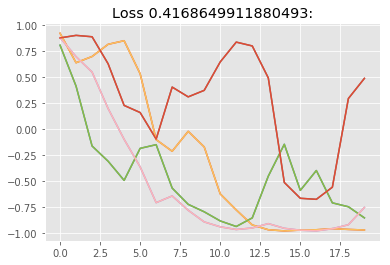

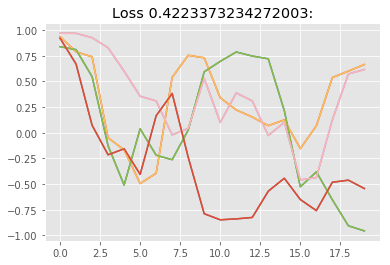

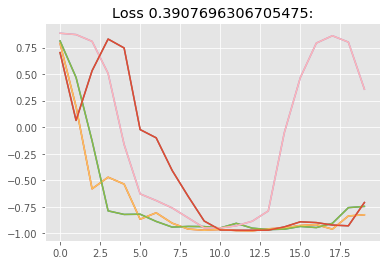

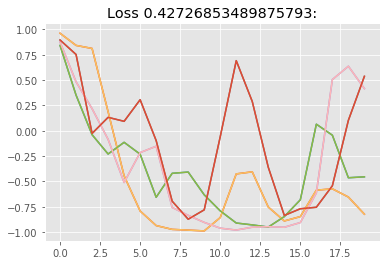

KeyboardInterrupt: 

In [272]:
e_bar = tqdm_notebook(range(1000))
G_losses = [1]
D_losses = [1]
logger = Logger('GAN-RNN-SIN')
for j, it in enumerate(e_bar):
    G_loss_avg = 0
    D_loss_avg = 0
    n_batches = 100
    b_bar = tqdm_notebook(range(n_batches), leave=False)
    
    DD = D_losses[-1]
    GG = G_losses[-1]
    
    for i in b_bar:
        z = Variable(g_noise()).cuda()
        X = Variable(real_sample()).cuda()
        
        G_sample = G(z)
        D_real = D(X)
        D_fake = D(G_sample)
        D_loss_real = F.binary_cross_entropy_with_logits(
            D_real, ones_label)
        D_loss_fake = F.binary_cross_entropy_with_logits(
            D_fake, zeros_label)     
        D_loss = D_loss_real + D_loss_fake
        D_loss.backward(retain_graph=True)
        D_solver.step()
        D_loss = D_loss.data[0]
        reset_grad()
        
        for _ in range(1):
            z = Variable(g_noise()).cuda()
            G_sample = G(z)
            D_fake = D(G_sample)
            G_loss = F.binary_cross_entropy_with_logits(
                D_fake, ones_label)
            G_loss.backward()
            G_solver.step()
            G_loss = G_loss.data[0]
            reset_grad()
        
        D_loss_avg += D_loss
        G_loss_avg += G_loss
        
        
    G_losses.append(G_loss_avg / n_batches)
    D_losses.append(D_loss_avg / n_batches)
    G_loss_avg = 0
    D_loss_avg = 0
    
    t = F.sigmoid(D_fake).mean().data.cpu().numpy().flatten()[0]
    if j%10 == 0:
        show_seqs(G_sample, j, t, ds=10)
    logger.log_scalar('loss/Disciminator', D_losses[-1])
    logger.log_scalar('loss/Generator', G_losses[-1])
    e_bar.set_postfix(
        G_loss=G_losses[-1],
        D_loss=D_losses[-1],
    )

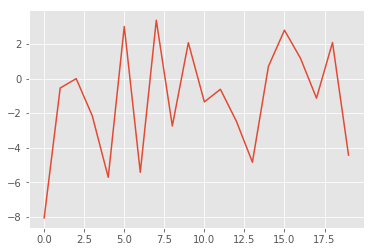

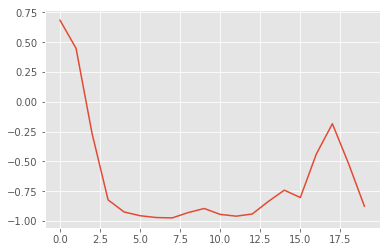

In [340]:
for _ in range(1):
    z = Variable(g_noise()).cuda()
    G_sample = G(z)
    ds = 100
    show_seqs_nosave(z, ds=ds)
    show_seqs_nosave(G_sample, ds=ds)

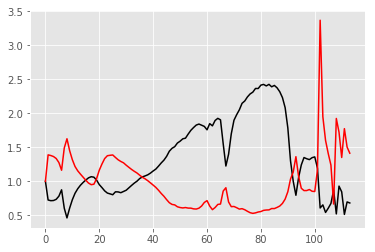

In [134]:
plt.plot(G_losses, c='k')
plt.plot(D_losses, c='r')